In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
from elmoformanylangs import Embedder


def read_in(path_to_file):
    out = []
    with open(path_to_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if not row[0] == "2":
                out.append([row[0], row[5]])
    return out


def preprocess(data):
    random.shuffle(data)
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        if row[0] == "0":
            label.append(0)
        else:
            label.append(1)
        cleaned = clean_regex(row[1].lower())
        tokenized = nltk.word_tokenize(cleaned)
        # pos_tagged = nltk.pos_tag(tokenized)
        tweet.append(tokenized)
    print("Done")
    return tweet, label


def clean_regex(tweet):
    cleaned = re.sub('@.*?(?:\s|$)', '', tweet)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    return cleaned3

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector




c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [2]:
print(os.getcwd())
base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
# 160.000 entries
training_data, training_label = preprocess(read_in(base_path + "/data/training.csv"))
test_data, test_label = preprocess(read_in(base_path + "/data/test.csv"))

C:\Users\Tobias.Nusser\AppData\Local\Programs\Python\Python37\Scripts
Preprocessing...
Done
Preprocessing...
Done


In [10]:
train_data = training_data[:120000]
train_label = np.asarray(training_label[:120000])
val_data = training_data[120000:140000]
val_label = np.asarray(training_label[120000:140000])

In [4]:
e = Embedder('C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning/elmo_embedding/144/')

In [ ]:
def get_embeddings(sentences):
    max_words = 50
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 25000 == 0:
            print(str(i))
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
    return results

train_embedding_matrix = get_embeddings(train_data)
val_embedding_matrix = get_embeddings(val_data)

0


In [12]:
from keras import losses
from keras import metrics

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(20,300,)))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20, 20)            6020      
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                8020      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 14,061
Trainable params: 14,061
Non-trainable params: 0
_________________________________________________________________
None
Train on 120000 samples, validate on 20000 samples
Epoch 1/20
120000/120000 [==============================] - ETA: 54s - loss: 0.6949 - acc: 0.48 - ETA: 23s - loss: 0.6937 - acc: 0.50 - ETA: 17s - loss: 0.6936 - acc: 0.49 - ETA: 14s - loss: 0.6931 - acc: 0.50 - ET

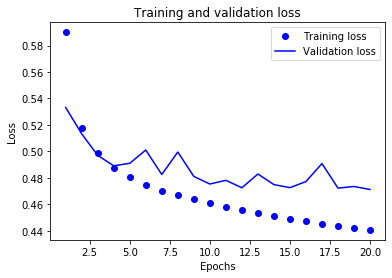

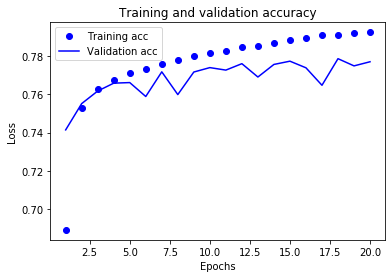

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

-0.11091375
0.008877111
0.041507237
0.19598632
0.31488547
-0.046621244
0.2736505
-0.0691031
0.3548101
0.15635702
0.24372423
0.18559174
0.9793021
0.18443806
-0.23464046
0.0052738637
0.0031089038
-0.18698065
0.2079593
0.11463144
-0.10786042
-0.24317734
-0.14215212
0.102522135
-0.2981081
0.13450651
0.23602791
-0.4801046
0.2539984
-0.24391405
-0.029092727
0.18223055
0.09517767
-0.13520545
0.09091284
0.30692294
0.24069746
-0.28512964
0.33048022
-0.07097506
-0.09221519
-0.1652328
-0.33075517
-0.016890997
0.0139631955
-0.119421154
-0.37051785
-0.37316385
-0.095401585
-0.25344345
-0.05192109
0.034421783
0.27615622
-0.57339597
0.0751363
0.0941171
0.08628335
0.32387567
-0.36299443
-0.036902864
-0.19911945
0.095596254
-0.081188135
-0.26780972
-0.011019905
-0.14474072
0.34155563
0.037836917
0.078828536
0.30356064
-0.032057073
-0.1759609
0.112110294
0.08095488
-0.24822254
-0.12194272
-0.47763786
-0.31580195
-0.33460107
-0.18843506
-0.07805734
0.11035401
-0.25655046
-0.3516175
0.01769075
0.18463303
